# Identifying Experimental Leverage

In this notebook, we'll explore how we can use system dynamics to identify the differences between different theories.

things we can observe over time:
- still employed
- sales

things we can observe over the life of the simulation:
- tenure
- cumulative sales
- cumulative income

things we can control:
- fraction of time for sales
- startup subsidy
- subsidy length
- Effort required to make a sale

In the market model alone:
- income from tier 1 vs tier 2 sales
- leads and clients


In [47]:
%pylab inline
import pysd
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [48]:
motivation_model = pysd.read_vensim('../../models/Sales_Agents/Sales_Agent_Motivation_Dynamics.mdl')
market_model = pysd.read_vensim('../../models/Sales_Agents/Sales_Agent_Market_Building_Dynamics.mdl')

In [49]:
def runner(params):
    market = market_model.run(dict(params),return_columns=['Tenure'])
    motiv = motivation_model.run(dict(params),return_columns=['Tenure'])
    return pd.Series({'market':market['Tenure'].iloc[-1], 
                      'motivation':motiv['Tenure'].iloc[-1]})

In [25]:
# define the sample space
ranges = {'Fraction of Effort for Sales':(0,1),
          'Startup Subsidy':(0,2),
          'Startup Subsidy Length':(0,12)}


In [42]:
# base case
base = runner({'Fraction of Effort for Sales': .25,
               'Startup Subsidy': 0,
               'Startup Subsidy Length': 0})
base

market         6.875
motivation    10.625
dtype: float64

In [26]:
f_sales = pd.DataFrame(np.arange(0,1,.1), 
                       columns=['Fraction of Effort for Sales'])
f_sales['Startup Subsidy'] = 0
f_sales['Startup Subsidy Length'] = 0
f_sales

,Fraction of Effort for Sales,Startup Subsidy,Startup Subsidy Length
0,0.0,0,0
1,0.1,0,0
2,0.2,0,0
3,0.3,0,0
4,0.4,0,0
5,0.5,0,0
6,0.6,0,0
7,0.7,0,0
8,0.8,0,0
9,0.9,0,0


<IPython.core.display.Javascript object>


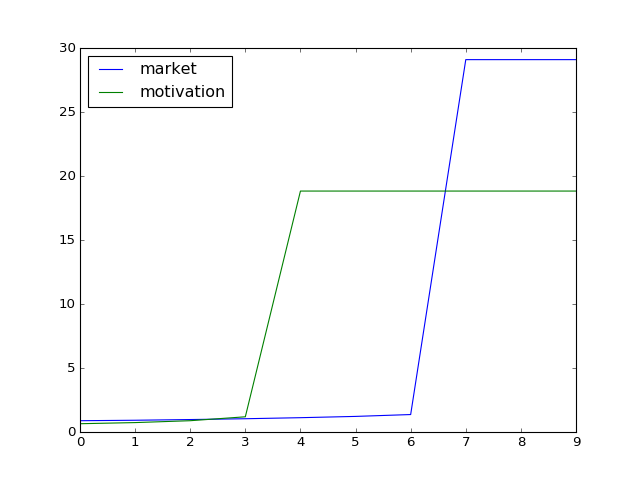

In [45]:
f_sales_res = f_sales.apply(runner, axis=1)/base
f_sales_res.plot()

In [33]:
subsidy = pd.DataFrame(np.arange(0,1,.1), 
                       columns=['Startup Subsidy'])
subsidy['Fraction of Effort for Sales'] = .25
subsidy['Startup Subsidy Length'] = 3
subsidy

,Startup Subsidy,Fraction of Effort for Sales,Startup Subsidy Length
0,0.0,0.25,3
1,0.1,0.25,3
2,0.2,0.25,3
3,0.3,0.25,3
4,0.4,0.25,3
5,0.5,0.25,3
6,0.6,0.25,3
7,0.7,0.25,3
8,0.8,0.25,3
9,0.9,0.25,3


In [34]:
subsidy.apply(runner, axis=1)

,market,motivation
0,6.8750,10.6250
1,7.2500,11.5000
2,7.6250,12.1875
3,8.0000,12.7500
4,8.3750,13.2500
5,8.8125,13.6875
6,9.1875,14.0625
7,9.5625,14.3750
8,10.0000,14.6875
9,10.3750,15.0000


In [35]:
l_subsidy = pd.DataFrame(np.arange(0,12,1), 
                       columns=['Startup Subsidy Length'])
l_subsidy['Fraction of Effort for Sales'] = .25
l_subsidy['Startup Subsidy'] = .5
l_subsidy

,Startup Subsidy Length,Fraction of Effort for Sales,Startup Subsidy
0,0,0.25,0.5
1,1,0.25,0.5
2,2,0.25,0.5
3,3,0.25,0.5
4,4,0.25,0.5
5,5,0.25,0.5
6,6,0.25,0.5
7,7,0.25,0.5
8,8,0.25,0.5
9,9,0.25,0.5


In [36]:
l_subsidy.apply(runner, axis=1)

,market,motivation
0,6.8750,10.6250
1,7.5000,11.6250
2,8.1250,12.6875
3,8.8125,13.6875
4,9.4375,14.6875
5,10.1250,15.7500
6,10.8125,16.7500
7,11.5000,17.7500
8,12.2500,18.7500
9,13.0625,19.7500


In [39]:
total_subsidy = pd.DataFrame(np.arange(0.1,1,.1), 
                       columns=['Startup Subsidy'])
total_subsidy['Fraction of Effort for Sales'] = .25
total_subsidy['Startup Subsidy Length'] = 10/total_subsidy['Startup Subsidy']
total_subsidy

,Startup Subsidy,Fraction of Effort for Sales,Startup Subsidy Length
0,0.1,0.25,100.000000
1,0.2,0.25,50.000000
2,0.3,0.25,33.333333
3,0.4,0.25,25.000000
4,0.5,0.25,20.000000
5,0.6,0.25,16.666667
6,0.7,0.25,14.285714
7,0.8,0.25,12.500000
8,0.9,0.25,11.111111


In [40]:
total_subsidy.apply(runner, axis=1)

,market,motivation
0,7.8750,100.5000
1,9.2500,52.8750
2,11.3750,42.1875
3,41.8125,35.0000
4,41.8125,30.7500
5,41.9375,28.0000
6,41.9375,26.1250
7,41.8125,24.6875
8,41.9375,23.6875
